In [66]:
#import relevant libraries 
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import accuracy_score # 
import numpy as np
import pandas as pd
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt 
%matplotlib inline

In [67]:
df= pd.read_csv("data.csv",delimiter=',',na_values='?')

In [68]:
# Set the data (X) and target (Y) values
Y=np.array(df['Overall'])
X = df.drop(columns=['Overall',])
# Print the shape of data (X) and target (Y) values
#Y = Y.reshape(Y.shape[0],1) 
print(X.shape)
print(Y.shape)
print(Y)

(8761, 42)
(8761,)
[80 80 79 ... 72 72 70]


In [69]:
#preprocess data
X_scale = StandardScaler()
X = X_scale.fit_transform(X)
print(X)

[[-0.71041556  2.00491451 -0.61524282 ... -0.4054824  -0.34564475
  -0.55435557]
 [ 1.48154517  1.03991819 -0.61524282 ... -0.34894113 -0.0757234
  -0.55435557]
 [-0.22331317  1.23291745 -0.61524282 ...  3.43932381  3.7031755
  -0.55435557]
 ...
 [-1.44106913  1.42591671  0.05420611 ... -0.51856494 -0.39962902
   0.06725849]
 [-1.68462032  1.42591671  0.05420611 ... -0.29239987 -0.23767621
   0.06725849]
 [-1.68462032  1.81191524 -0.09307266 ... -0.34894113 -0.6155661
   0.06725849]]


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [70]:
#Split the data into training and test set.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =0.3)
print (X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(6132, 42) (2629, 42) (6132,) (2629,)


In [71]:
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 95))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

In [72]:
# convert digits to vectors
y_v_train = convert_y_to_vect(Y_train)
y_v_test = convert_y_to_vect(Y_test)
print (y_v_train.shape, y_v_test.shape)

(6132, 95) (2629, 95)


In [73]:
def f(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))


def f_deriv(z):
    return 1 - f(z)*f(z)

In [74]:
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

In [75]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

In [76]:
def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

In [83]:
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    regularized = -(y-a_out) * f_deriv(z_out)
    return regularized


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

In [84]:
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25, lamb = 0.15):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%100 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/N * tri_W[l] + lamb*W[l])
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

In [85]:
nn_structure = [42, 40, 95]
    
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 1500)

Starting gradient descent for 1500 iterations
Iteration 0 of 1500
Iteration 100 of 1500
Iteration 200 of 1500
Iteration 300 of 1500
Iteration 400 of 1500
Iteration 500 of 1500
Iteration 600 of 1500
Iteration 700 of 1500
Iteration 800 of 1500
Iteration 900 of 1500
Iteration 1000 of 1500
Iteration 1100 of 1500
Iteration 1200 of 1500
Iteration 1300 of 1500
Iteration 1400 of 1500


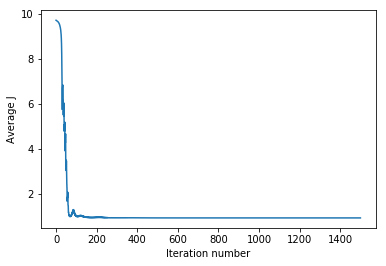

In [86]:
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

In [90]:
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
y_pred_train = predict_y(W, b, X_train, 3)
print('Prediction test accuracy is {}%'.format(accuracy_score(Y_test, y_pred) * 100))
print('Prediction training accuracy is {}%'.format(accuracy_score(Y_train, y_pred_train) * 100))

Prediction test accuracy is 12.818562190947128%
Prediction training accuracy is 13.486627527723419%
